In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Running functions_IT.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IT/functions_IT_v2.ipynb

In [2]:
ssh_it = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/ssh_it_*.nc",combine='nested',concat_dim='time_counter',parallel=True).load()


To cartesian grid

In [ ]:
# Select the first date
first_date_ssh = ssh_it.isel(time_counter=0)

# Create a cartesian grid
dx = 2  # in kilometers
ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(first_date_ssh.nav_lat[:, 0].values, first_date_ssh.nav_lon[0, :].values, dx)

# Flatten the grids
ENSLAT2D_flat = ENSLAT2D.flatten()
ENSLON2D_flat = ENSLON2D.flatten()

# Prepare the points and values for interpolation
points = np.column_stack((first_date_ssh.nav_lat.data.flatten(), first_date_ssh.nav_lon.data.flatten()))
values = first_date_ssh.ssh_it.data.flatten()
target_grid = np.column_stack((ENSLAT2D_flat, ENSLON2D_flat))

# Interpolate the data to the new grid
array_cart_ssh = griddata(points, values, target_grid, method='linear')

# Reshape the interpolated data to the grid shape
array_cart_ssh = array_cart_ssh.reshape(ENSLAT2D.shape)

In [ ]:
# Filling step
x_axis = Axis(np.arange(i_lon))
y_axis = Axis(np.arange(i_lat))

grid = Grid2D(y_axis, x_axis, array_cart_ssh.reshape((i_lat, i_lon)))
has_converged, filled = fill.gauss_seidel(grid)

# Create a mask for NaNs in the interpolated array
mask_cart = np.isnan(array_cart_ssh.reshape((i_lat, i_lon)))

# Create a new DataArray with the filled data
cart_it = xr.DataArray(
    data=filled,
    dims=["y", "x"],
    coords=dict(
        y=(["y"], np.arange(i_lat)),
        x=(["x"], np.arange(i_lon))
    )
)

In [ ]:
plt.figure()
plt.pcolormesh(cart_it,cmap=cmocean.cm.curl, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()

For the rest if the dataset

In [ ]:
# Define the grid spacing
dx = 2  # in kilometers

# Process each time step in parallel
results = Parallel(n_jobs=-1)(delayed(process_time_step)(time_idx, ssh_it, dx) for time_idx in range(ssh_it.sizes['time_counter']))

# Combine all the results into a single Dataset
combined_results = xr.concat(results, dim='time_counter')

# Takes like 50 minutes to run with 16 cores

In [ ]:
combined_results

In [ ]:
# Save path
save_path = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/"

# Define the time range for each month, ensuring the end time is included up to 23:00
time_ranges = {
    "05": ("2014-05-01 00:30", "2014-05-31 23:30"),
    "06": ("2014-06-01 00:30", "2014-06-30 23:30"),
    "07": ("2014-07-01 00:30", "2014-07-31 23:30")
}

# Iterate over each time range and save the corresponding data
for month, (start_date, end_date) in time_ranges.items():
    # Select the data for the given time range
    ssh_it_month = combined_results.sel(time_counter=slice(start_date, end_date))
    
    # Wrap the DataArray in a Dataset and rename the data variable to ssh_it_cart
    ssh_it_month_ds = ssh_it_month.to_dataset(name="ssh_it_cart")
    
    # Define the filename
    filename = f"ssh_it_cart_{month}.nc"
    
    # Save the dataset to a NetCDF file
    ssh_it_month_ds.to_netcdf(save_path + filename)
    
    print(f"Saved {filename} to {save_path}")

In [3]:
ssh_it_cart = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/analysis/ssh_it_cart_*.nc",combine='nested',concat_dim='time_counter',parallel=True).load()

In [4]:
res_ssh_it_cart = xrft.isotropic_power_spectrum(ssh_it_cart.ssh_it_cart,dim=['x','y']).mean(["time_counter"])

/home/riverama/.conda/envs/env-stage/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


In [6]:
res_ssh_it_cart


<xarray.DataArray (freq_r: 185)> Size: 1kB
array([9.29430360e-05, 7.79253439e-03, 5.39854542e-03, 8.95048879e-03,
       3.41517998e-03, 1.29294856e-03, 1.00927076e-03, 6.07398331e-04,
       2.71081529e-04, 1.75635941e-04, 1.56486931e-04, 1.09447167e-04,
       7.58892465e-05, 5.47354413e-05, 4.21838694e-05, 3.16034539e-05,
       2.52039558e-05, 2.06050916e-05, 1.55556407e-05, 1.28001853e-05,
       1.03451422e-05, 8.27844741e-06, 6.77590182e-06, 5.49496958e-06,
       4.59753115e-06, 3.95136448e-06, 3.46681935e-06, 3.17196070e-06,
       2.91387024e-06, 2.58487814e-06, 2.30413408e-06, 2.24120872e-06,
       2.07426127e-06, 1.98321610e-06, 1.83031656e-06, 1.61055411e-06,
       1.43981415e-06, 1.47560186e-06, 1.32974556e-06, 1.23543431e-06,
       1.09645185e-06, 1.01538421e-06, 9.29951189e-07, 9.32606467e-07,
       8.34134641e-07, 7.65949134e-07, 7.69287316e-07, 7.77439364e-07,
       7.18285001e-07, 7.20115123e-07, 6.84172278e-07, 6.54708365e-07,
       5.97982323e-07, 5.74661643e-07, 5.45534294e-07, 5.78553172e-07,
       5.48029764e-07, 5.35316427e-07, 5.05066250e-07, 4.73739275e-07,
       4.21198344e-07, 4.41420954e-07, 4.53760461e-07, 4.29745043e-07,
       3.97458486e-07, 3.56917463e-07, 3.35302642e-07, 3.46261411e-07,
       3.50274367e-07, 3.32161947e-07, 3.20789439e-07, 2.91620250e-07,
       2.75403466e-07, 2.80502267e-07, 2.73966217e-07, 2.55723036e-07,
       2.50259967e-07, 2.33043388e-07, 2.26521684e-07, 2.25624255e-07,
...
       1.37325672e-07, 1.23724699e-07, 1.47704029e-07, 1.44193925e-07,
       1.44697773e-07, 1.41542139e-07, 1.26976170e-07, 1.13258110e-07,
       1.41289655e-07, 1.36842614e-07, 1.38244996e-07, 1.36785817e-07,
       1.30910604e-07, 1.11203816e-07, 1.37693556e-07, 1.41772540e-07,
       1.43438235e-07, 1.43668200e-07, 1.38686444e-07, 1.12293168e-07,
       1.34734806e-07, 1.44339752e-07, 1.46715284e-07, 9.23692765e-09,
       7.28228348e-09, 6.69331417e-09, 6.61290576e-09, 6.60951395e-09,
       6.40932939e-09, 6.35781793e-09, 6.16810209e-09, 6.27773658e-09,
       6.31880811e-09, 6.24533166e-09, 6.34366998e-09, 6.18572121e-09,
       6.28063902e-09, 5.89949543e-09, 6.09486720e-09, 6.30567127e-09,
       6.38121644e-09, 6.30589723e-09, 6.54710244e-09, 6.48824590e-09,
       6.29383342e-09, 6.27701906e-09, 6.90997948e-09, 6.80741523e-09,
       7.12765131e-09, 7.27733058e-09, 6.91174405e-09, 6.82084544e-09,
       7.24070893e-09, 7.39621747e-09, 7.65223542e-09, 8.35703396e-09,
       7.94098254e-09, 7.90964769e-09, 7.82898509e-09, 9.37724005e-09,
       1.01839386e-08, 1.01627081e-08, 1.05259937e-08, 1.00769887e-08,
       1.02110364e-08, 1.10471895e-08, 1.07135729e-08, 1.03955409e-08,
       1.00826288e-08, 8.69595531e-09, 7.38608445e-09, 6.06950096e-09,
       5.99547311e-09, 5.98804684e-09, 3.25704771e-09, 3.16938187e-09,
       3.99344210e-09])
Coordinates:
  * freq_r   (freq_r) float64 1kB 0.002523 0.005922 0.009637 ... 0.6998 0.7036

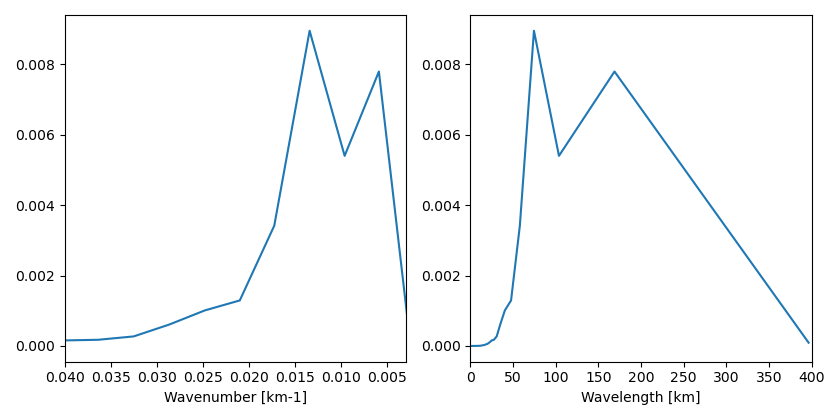

In [7]:
# Create a figure and two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(8.4, 4.2))  # figsize is adjustable based on your display preferences

# First subplot for Wavenumber vs. Data
axs[0].plot(res_ssh_it_cart.freq_r.values, res_ssh_it_cart.values)
axs[0].set_xlim(0.04, 0.003)  # Note: Check if you need the limits reversed or not
axs[0].set_xlabel("Wavenumber [km-1]")

# Second subplot for Wavelength vs. Data
axs[1].plot(1/res_ssh_it_cart.freq_r.values, res_ssh_it_cart.values)
axs[1].set_xlim(0, 400)
axs[1].set_xlabel("Wavelength [km]")

# Improve layout to prevent overlap of subplot elements
plt.tight_layout()

# Display the combined plots
plt.show()

In [ ]:
from scipy.signal import find_peaks

wavenumbers = res_ssh_it_cart.freq_r.values
values = res_ssh_it_cart.values

# Finding peaks and troughs
peaks, _ = find_peaks(values)
troughs, _ = find_peaks(-values)

# Extracting the peak and trough values
peak_wavenumbers = wavenumbers[peaks]
peak_values = values[peaks]
trough_wavenumbers = wavenumbers[troughs]
trough_values = values[troughs]

# Creating a table for display
import pandas as pd

peaks_df = pd.DataFrame({
    "Peak Wavenumbers (km-1)": peak_wavenumbers,
    "Peak Amplitude": peak_values
})

troughs_df = pd.DataFrame({
    "Trough Wavenumbers (km-1)": trough_wavenumbers,
    "Trough Amplitude": trough_values
})

peaks_df, troughs_df


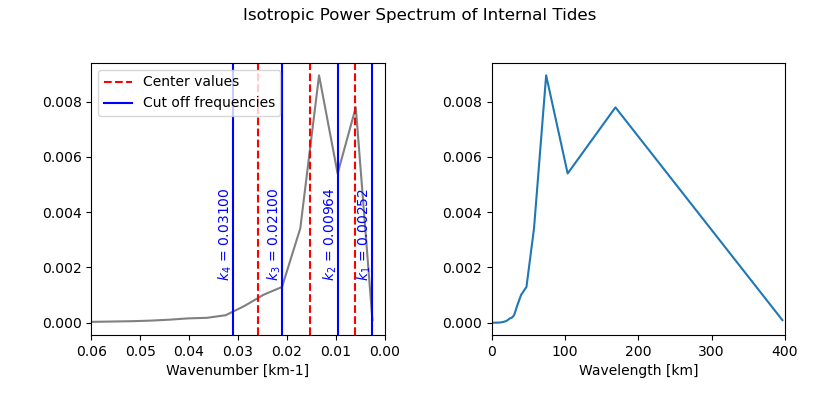

In [25]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create a figure and two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(8.4, 4.2))  # figsize is adjustable based on your display preferences

# First subplot for Wavenumber vs. Data
axs[0].plot(res_ssh_it_cart.freq_r.values, res_ssh_it_cart.values, color='gray')
axs[0].set_xlim(0.06, 0)  # Check if you need the limits reversed
axs[0].set_xlabel("Wavenumber [km-1]")

# Add blue dotted lines at specific peaks
peak_positions = [0.002523, 0.009637, 0.0210, 0.031]
for i, peak in enumerate(peak_positions):
    axs[0].axvline(x=peak, color='blue', linestyle='-', label=f'Peak $k_{{ {i+1} }}$')
    axs[0].text(peak - 0.0002, 0.0015, f'$k_{{ {i+1} }}$ = {peak:.5f}', 
                color='blue', rotation=90, verticalalignment='bottom', horizontalalignment='right')

# Add red solid lines at specific troughs
#trough_positions = [0.00592, 0.01343, 0.0265]
trough_positions = [0.00608,0.0153185,0.026]
for trough in trough_positions:
    axs[0].axvline(x=trough, color='red', linestyle='--', label='Trough')

# Second subplot for Wavelength vs. Data
axs[1].plot(1/res_ssh_it_cart.freq_r.values, res_ssh_it_cart.values)
axs[1].set_xlim(0, 400)
axs[1].set_xlabel("Wavelength [km]")

# Adjust layout and create space for super title
plt.tight_layout(pad=3.0)  # Increase pad size if necessary
fig.subplots_adjust(top=0.85)  # Adjust the top margin so the suptitle fits within the figure canvas

# Create custom legends
blue_line = mlines.Line2D([], [], color='red', linestyle='--', label='Center values')
red_line = mlines.Line2D([], [], color='blue', linestyle='-', label='Cut off frequencies')
axs[0].legend(handles=[blue_line, red_line])

# Set super title for the figure
fig.suptitle('Isotropic Power Spectrum of Internal Tides')

# Display the combined plots
plt.show()
